In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing + Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset (automatically assigns labels from folder names)
dataset = datasets.ImageFolder("dataset", transform=transform)

# Split into train & validation
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [3]:
import torch
import torch.nn as nn
from torchvision import models

# Use MPS for Apple Silicon, fall back to CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 3 classes
model.fc = nn.Linear(model.fc.in_features, 3)

# Move model to device
model = model.to(device)


Using device: mps


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.5085
Epoch 2, Loss: 0.2849
Epoch 3, Loss: 0.2323
Epoch 4, Loss: 0.2315
Epoch 5, Loss: 0.1834


In [5]:
from sklearn.metrics import classification_report,confusion_matrix

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=dataset.classes))


                 precision    recall  f1-score   support

   Bengin cases       0.96      0.95      0.95       228
Malignant cases       0.95      0.96      0.96       245

       accuracy                           0.96       473
      macro avg       0.96      0.96      0.96       473
   weighted avg       0.96      0.96      0.96       473



In [6]:
torch.save(model.state_dict(), "spn_classifier.pth")

In [7]:
def generate_confusion_matrix(model_name,y_test, y_predicted):
  cmatrix = confusion_matrix(y_test, y_predicted)
  sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Greens', xticklabels=dataset.classes, yticklabels=dataset.classes)
  plt.title(f"{model_name} Confusion Matrix")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

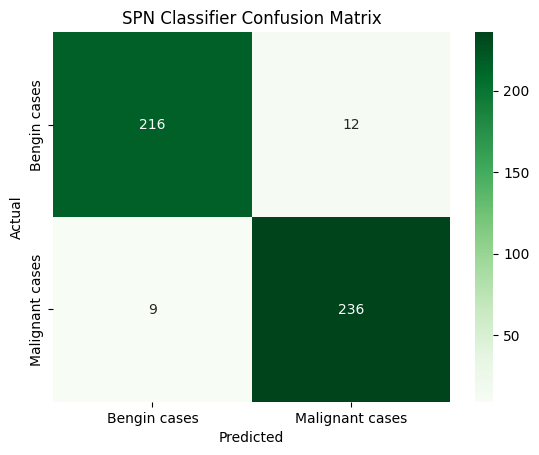

In [8]:
generate_confusion_matrix("SPN Classifier", y_true, y_pred)

In [9]:
def generate_classification_report(y_test, y_predicted,target_names=None):
  report = classification_report(y_test, y_predicted, output_dict=True, target_names=target_names)
  report_df = pd.DataFrame(report).transpose()
  return report_df

In [10]:
generate_classification_report(y_true, y_pred,target_names=dataset.classes)

,precision,recall,f1-score,support
Bengin cases,0.960000,0.947368,0.953642,228.000000
Malignant cases,0.951613,0.963265,0.957404,245.000000
accuracy,0.955603,0.955603,0.955603,0.955603
macro avg,0.955806,0.955317,0.955523,473.000000
weighted avg,0.955656,0.955603,0.955591,473.000000
